In [13]:
# Import

from __future__ import division
import os
import sys
import copy
import numpy as np
from numpy import ma
import math as m
import pandas as pd
import string
import cmasher as cmr

import pickle
from numpy import genfromtxt
from scipy.interpolate import griddata
from matplotlib import rc
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

import datetime
from matplotlib.dates import DayLocator, MonthLocator, HourLocator, AutoDateLocator, DateFormatter, drange
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator
from numpy import arange
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.cm as cm
import matplotlib.mlab as mlab

import glob

In [14]:
#%% Plot Settings

# Colors

darkblue = '#4e79a7'
orange = '#f28e2b'
red = '#e15759'
lightblue = '#76b7b2'
green = '#59a14f'
yellow = '#edc948'
purple = '#b07aa1'
pink = '#ff9da7'
brown = '#9c755f'
gray = '#bab0ac'

cbar_pad = 0.15

# Font / Figure Size
import matplotlib.pylab as pylab
params = {'legend.fontsize': '7',
         'axes.labelsize': '7',
         'axes.titlesize': '7',
         'xtick.labelsize': '7',
         'ytick.labelsize': '7',
          
         'xtick.major.pad': '7',
         'ytick.major.pad': '7',
         'axes.titlepad': 35,
         'axes.labelpad': 15,
         
         'font.sans-serif':'Avenir',
          'axes.linewidth': 0.5,
         'xtick.major.width': 0.5,
         'ytick.major.width': 0.5}
pylab.rcParams.update(params)

In [15]:
def all_nonzero(arr_iter):
    """return non zero elements of all arrays as a np.array"""
    return np.concatenate([a[a != 0] for a in arr_iter])

In [16]:
# toc: total installed cost ($/kWh for energy costs, $/kW for power costs)
# fhc: fixed hourly cost ($/kWh/h for energy costs, $/kW/h for power costs)

hours_per_year = 8760 # number of hours in a year (h/yr)
crf = 0.0806 # capital recovery factor, assuming a discount rate of 7% and 30 year lifetime (%/yr)
fixed_om = 0.015 # Fixed O&M (% of capital cost)
fixed_ptilp = 0.015 # Fixed property tax, insurance, licencing, permiting (% of capital cost)

# functions to calculate fhc from toc of technologies
def get_energy_fhc(toc):
    return ((toc + fixed_om * toc) * crf) / hours_per_year

def get_energy_toc(fhc):
    return (fhc * hours_per_year) / crf / (1 + fixed_om)

def get_power_fhc(toc):
    return ((toc + fixed_ptilp * toc) * crf) / hours_per_year

def get_power_toc(fhc):
    return (fhc * hours_per_year) / crf / (1 + fixed_ptilp)

In [17]:
def reshape(data):
    # X and Y axes
    x = data['third_tech_energy_cost']
    y = data['third_tech_power_cost']
    
    X = list(set(x))
    X.sort()
    Y = list(set(y))
    Y.sort()
    
    for key in data.keys():
        if len(data[key]) > 0:
            data[key] = np.reshape(data[key], (len(Y), len(X)))
    
    data['X'] = X
    data['Y'] = Y

def existence(data):
    epsilon = 10**-3
    data['pgp_exist'] = data['PGP_storage_cap'] > epsilon
    data['third_tech_exist'] = data['third_tech_energy_cap'] > epsilon
    
    # What is the number of technologies
    data['num_techs'] = sum([data['pgp_exist'], data['third_tech_exist']])
    
    # Scatterplot data for if technology exists or not
    data['pgp_exist_scatter_energy'] = all_nonzero(np.multiply(data['third_tech_energy_cost'], data['pgp_exist']))
    data['pgp_exist_scatter_power'] = all_nonzero(np.multiply(data['third_tech_power_cost'], data['pgp_exist']))
    data['third_tech_exist_scatter_energy'] = all_nonzero(np.multiply(data['third_tech_energy_cost'], data['third_tech_exist']))
    data['third_tech_exist_scatter_power'] = all_nonzero(np.multiply(data['third_tech_power_cost'], data['third_tech_exist']))    
    data['both_exist_scatter_energy'] = all_nonzero(np.multiply(data['third_tech_energy_cost'], data['num_techs'] == 2))
    data['both_exist_scatter_power'] = all_nonzero(np.multiply(data['third_tech_power_cost'], data['num_techs'] == 2))
            
def prop(data):
    PGP_dispatch = data['from_PGP_tot_dispatch']
    third_tech_dispatch = data['third_tech_energy_tot_dispatch']
    tot_dispatch = sum(np.array([PGP_dispatch, third_tech_dispatch]))
    data['PGP_prop'] = np.divide(PGP_dispatch, tot_dispatch)
    data['third_tech_prop'] = np.divide(third_tech_dispatch, tot_dispatch)
    data['dispatch_eff_num_batt'] = np.divide(1, np.square(data['PGP_prop']) + np.square(data['third_tech_prop']))
    
def storage_cost_cont(data):
    pgp = data['pgp_cost']
    third_tech = data['third_tech_cost']
    tot_storage_tech_cost = sum(np.array([pgp, third_tech]))
    data['pgp_cost_cont'] = np.divide(pgp, tot_storage_tech_cost)
    data['third_tech_cost_cont'] = np.divide(third_tech, tot_storage_tech_cost)
    data['cost_eff_num_batt'] = np.divide(1, np.square(data['pgp_cost_cont']) + np.square(data['third_tech_cost_cont']))

In [18]:
# Import Data

from extract_data_param_PGP_X import get_data_one_power

# two tech case

path = '../Output_Data/Param_Two_Techs_PGP_X'
data = get_data_one_power(path, 7, 'fixed_cost', 8, 'fixed_cost', False)

data['third_tech_energy_cost'] = [get_energy_toc(i) for i in data['third_tech_energy_cost']]
data['third_tech_power_cost'] = [get_power_toc(i) for i in data['third_tech_power_cost']]

# one tech case
one_tech_path = '../Output_Data/CONUS/Two_Techs_PGP_X/PGP'
one_tech_data = get_data_one_power(one_tech_path, 2, 'fixed_cost', 3, 'fixed_cost', False)

reshape(data)
existence(data)
prop(data)
storage_cost_cont(data)

In [19]:
# Functions for marking Li-ion and PGP energy/power-capacity total overnight costs

batt_energy_toc = 326.4
batt_power_toc = 250.92

pgp_energy_toc = 1.9992
pgp_power_toc = 1560.6

w=1
l=10

def current_PGP_current_li_ion(ax):
    energy_ticks = ax.twiny()
    energy_ticks.set_xlim(ax.get_xlim())
    energy_ticks.set_xticks([pgp_energy_toc])
    energy_ticks.set_xticklabels(['$H_2$'])
    energy_ticks.tick_params(direction='inout', length=l, width=w, pad=2.5)
    
    power_ticks = ax.twinx()
    power_ticks.set_ylim(ax.get_ylim())
    power_ticks.set_yticks([pgp_power_toc])
    power_ticks.set_yticklabels(['$H_2$'])
    power_ticks.tick_params(direction='inout', length=l, width=w, pad=2.5)

/var/folders/_n/__95sd_157z4_g0kbd99cm1m0000gn/T/ipykernel_1836/644480299.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
/var/folders/_n/__95sd_157z4_g0kbd99cm1m0000gn/T/ipykernel_1836/644480299.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)


Text(-0.55, 1.35, 'B')

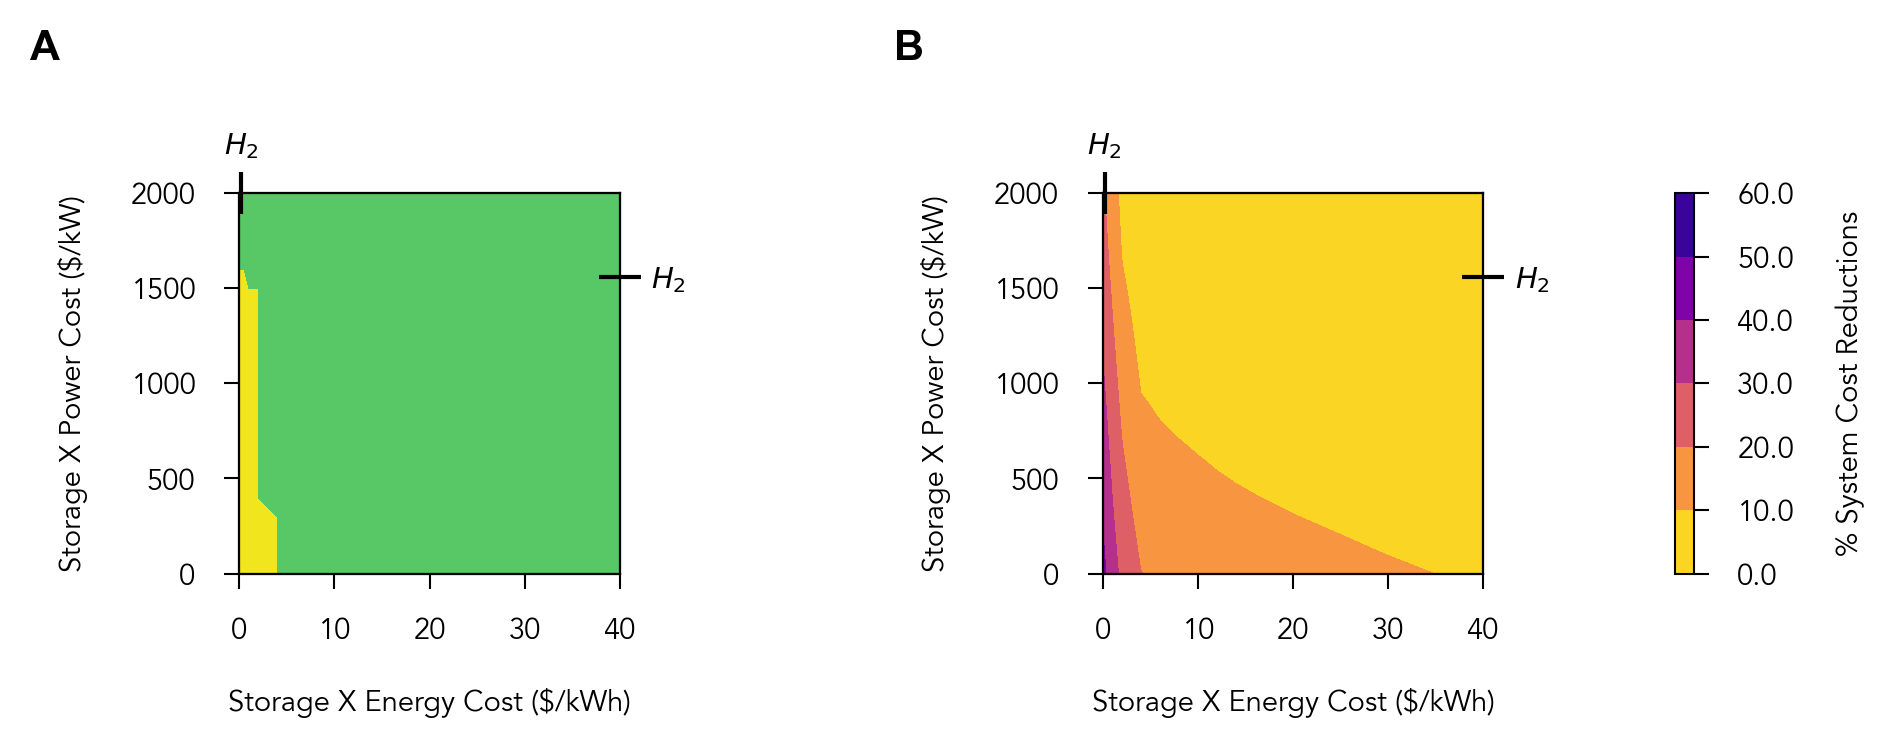

In [22]:
mm = 1/25.4 # millimeters in inches
fig_w = 172*mm
fig_h = (172/3)*mm
fig = plt.subplots(nrows=1,ncols=2, figsize=(fig_w, fig_h), dpi=300)

X = data['X']
Y = data['Y']

num_techs_cmap = cmr.get_sub_cmap('viridis_r', 0.02, 0.98)
cost_reduction_cmap = 'plasma_r'

###################################################
# Figure 2a: When do 1, 2, 3, technologies exist? #
###################################################

ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
cbar_ylabel1 = 'Number of Technologies'

Z1 = data['num_techs']
cpf1 = ax1.contourf(X, Y, Z1, cmap=num_techs_cmap, levels=[0,1,2,3], vmin=1, vmax=3)

#cbar1 = plt.colorbar(cpf1, ax=ax1, pad=0.1)
#cbar1.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
#cbar1.ax.set_ylabel(cbar_ylabel1, labelpad=10)

####################################################################
# Figure 2b: What is the effective number of storage technologies? #
####################################################################

ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
cbar_ylabel2 = '% System Cost Reductions'

Z2 = np.abs(np.around(((data['system_cost'] - one_tech_data['system_cost'][0]) / one_tech_data['system_cost'][0])*100, 10))

#levels2 = [1e-6, 0.001, 0.005, 0.01, 0.05]
#levels2 = [1e-4, 0.25, 0.5, 2.5, 5, 25, 50]

# log colorbar
#levels2 = [0.001, 0.1, 0.5, 2.5, 10, 50]
#cpf2 = ax2.contourf(X, Y, Z2, cmap=cost_reduction_cmap, levels=levels2, locator=ticker.LogLocator(), vmin=0.1, vmax=30)

# linear colorbar
levels2 = [0.01, 10, 20, 30, 40, 50, 60]
cpf2 = ax2.contourf(X, Y, Z2, cmap=cost_reduction_cmap, levels=levels2)

cbar2 = plt.colorbar(cpf2, ax=ax2, pad=0.1)
cbar2.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
cbar2.ax.set_ylabel(cbar_ylabel2, labelpad=10)

# Show where 3 techs compete
'''
dotsize=1.5
dotcolor = 'gray'
dots_indices = [i for i,j in enumerate(data['both_exist_scatter_energy']) if ((j>=20) or (round(j,2)==0.01))]
dots_x = [data['both_exist_scatter_energy'][i] for i in tuple(dots_indices)]
dots_y = [data['both_exist_scatter_power'][i] for i in tuple(dots_indices)]
ax2.scatter(dots_x, dots_y, c=gray, s=dotsize)
'''    

# Axis labels, settings
axes = [ax1, ax2]
for ax in axes: 
    current_PGP_current_li_ion(ax)
    ax.set_xlim(0, 40)
    ax.set_ylim(0, 2000)
    ax.set_xlabel('Storage X Energy Cost ($/kWh)', labelpad=10)
    ax.set_ylabel('Storage X Power Cost ($/kW)', labelpad=10)
    ax.set_box_aspect(1)

# Adjust distance between subplots

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.45)

ax1.text(-0.55, 1.35, 'A', transform=ax1.transAxes, fontsize=10, fontweight='bold', name='Arial')
ax2.text(-0.55, 1.35, 'B', transform=ax2.transAxes, fontsize=10, fontweight='bold', name='Arial')

#if not os.path.exists('Figures'):
#    os.makedirs('Figures')
#plt.savefig('Figures/Fig_7_PGP_X_Num_Techs_Cost.png', dpi=300, bbox_inches='tight')

In [ ]:
def show_data(parameter):
    pd.set_option('display.max_columns', None)
    df = pd.DataFrame(np.around(data[parameter], decimals=2))
    df = df.iloc[::-1]
    display(df)

In [ ]:
show_data(Z2)

TypeError: ignored

In [ ]:
show_data('third_tech_energy_cost')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
20,0.01,0.1,0.25,0.5,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,200.0,220.0,240.0,260.0,280.0,300.0,320.0,340.0,360.0,380.0
19,0.01,0.1,0.25,0.5,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,200.0,220.0,240.0,260.0,280.0,300.0,320.0,340.0,360.0,380.0
18,0.01,0.1,0.25,0.5,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,200.0,220.0,240.0,260.0,280.0,300.0,320.0,340.0,360.0,380.0
17,0.01,0.1,0.25,0.5,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,200.0,220.0,240.0,260.0,280.0,300.0,320.0,340.0,360.0,380.0
16,0.01,0.1,0.25,0.5,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,200.0,220.0,240.0,260.0,280.0,300.0,320.0,340.0,360.0,380.0
15,0.01,0.1,0.25,0.5,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,200.0,220.0,240.0,260.0,280.0,300.0,320.0,340.0,360.0,380.0
14,0.01,0.1,0.25,0.5,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,200.0,220.0,240.0,260.0,280.0,300.0,320.0,340.0,360.0,380.0
13,0.01,0.1,0.25,0.5,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,200.0,220.0,240.0,260.0,280.0,300.0,320.0,340.0,360.0,380.0
12,0.01,0.1,0.25,0.5,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,200.0,220.0,240.0,260.0,280.0,300.0,320.0,340.0,360.0,380.0
11,0.01,0.1,0.25,0.5,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,200.0,220.0,240.0,260.0,280.0,300.0,320.0,340.0,360.0,380.0


In [ ]:
df = pd.DataFrame(Z2)
df = df.iloc[::-1]
display(df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
20,21.427489,20.756593,19.640050,17.784259,14.100991,7.644198,3.079310,2.518443,2.105511,1.814776,1.557970,1.368024,1.201932,1.068422,0.947271,0.301492,0.122805,0.036617,0.003489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19,22.283578,21.608859,20.485839,18.617379,14.903300,8.232821,3.464308,2.881552,2.450382,2.147145,1.877491,1.666780,1.481747,1.328582,1.190933,0.443456,0.210594,0.094153,0.033241,0.004258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18,23.174331,22.496178,21.366576,19.487726,15.743523,8.875642,3.904518,3.306377,2.850324,2.531986,2.252912,2.026290,1.821557,1.645076,1.495837,0.635289,0.333990,0.183149,0.093721,0.037874,0.008433,0.000026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,24.114088,23.432928,22.297959,20.407386,16.633649,9.591211,4.414119,3.805261,3.329259,2.990670,2.701750,2.460439,2.242045,2.043342,1.878348,0.885696,0.505833,0.315063,0.193015,0.112217,0.055489,0.020695,0.003981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16,25.116710,24.433388,23.294516,21.396397,17.600218,10.435684,5.022616,4.376485,3.889130,3.528039,3.232459,2.974817,2.748413,2.536542,2.350884,1.206414,0.731687,0.500814,0.354528,0.239977,0.158410,0.097883,0.053209,0.024680,0.007430,0.000878,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,26.146565,25.463242,24.324371,22.426252,18.630013,11.471848,5.699192,4.974818,4.474388,4.098658,3.794759,3.518777,3.284912,3.067436,2.866192,1.563859,0.978007,0.699194,0.537307,0.409299,0.292719,0.208817,0.146332,0.093145,0.058684,0.036667,0.019409,0.011468,0.006702,0.001936,0.000000,0.000000,0.000000,0.000000
14,27.176420,26.493097,25.354225,23.456106,19.659868,12.531494,6.397206,5.595293,5.070283,4.692053,4.372162,4.084474,3.836462,3.613401,3.400208,1.972667,1.248210,0.905858,0.722877,0.590027,0.464069,0.345660,0.259358,0.196410,0.137304,0.095618,0.068607,0.049639,0.031700,0.022431,0.017664,0.012898,0.008132,0.003366
13,28.206274,27.522952,26.384080,24.485961,20.689723,13.594507,7.125671,6.242362,5.682789,5.295008,4.965543,4.672591,4.410425,4.171560,3.949150,2.383637,1.550811,1.125083,0.911597,0.770760,0.644797,0.518876,0.398926,0.310210,0.246676,0.184776,0.134197,0.102130,0.081089,0.062613,0.044282,0.033446,0.028627,0.023860
12,29.236129,28.552806,27.413935,25.515816,21.719577,14.661165,7.876709,6.917411,6.341947,5.937570,5.598649,5.293635,5.008529,4.751487,4.510784,2.796192,1.890696,1.361678,1.106101,0.952000,0.825526,0.699568,0.573718,0.452472,0.361223,0.296947,0.234504,0.177035,0.138052,0.112630,0.094072,0.075591,0.057115,0.044657
11,30.265984,29.582661,28.443789,26.545670,22.749432,15.731564,8.678209,7.642342,7.045563,6.598097,6.241642,5.922533,5.628707,5.351648,5.093779,3.220330,2.280920,1.618235,1.309317,1.136664,1.006260,0.880296,0.754369,0.628578,0.506260,0.412414,0.347246,0.284780,0.223533,0.175755,0.145745,0.125541,0.107058,0.088575


In [ ]:
print(len(data['all_three_exist_scatter_power']))

335
